# ML - Problem Set 1: Predicting Income

Un modelo de predicción de ingresos podría ayudar a detectar casos de fraude que podrían conducir a la reducción de la evasion impositiva. Además, un modelo de predicción de ingresos puede ayudar a identificar a las personas y familias vulnerables que pueden necesitar más ayuda.

Para ello, vamos a extraer información del siguiente [sitio](https://ignaciomsarmiento.github.io/GEIH2018_sample/). Este contiene datos de Bogotá del “Informe de Medicina de Pobreza Monetaria y Desigualdad” de 2018 que toma información del GEIH.

El objetivo principal es construir un modelo de salarios horarios individuales

\begin{equation}
w = f(X) + u \tag{1}
\end{equation}

donde $w$ es el salario por hora y $X$ es una matriz que incluye posibles variables explicativas/predictores. En este conjunto de problemas, nos centraremos en $f(X) = X \beta$.

## 1 Extraccion de datos

In [1]:
# ----------------------------------------------------------------------
# Importar librerias
# ----------------------------------------------------------------------
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import re
from sklearn.preprocessing import StandardScaler

In [ ]:
# ----------------------------------------------------------------------
# Adquisición de datos
# ----------------------------------------------------------------------
base_url = "https://ignaciomsarmiento.github.io/GEIH2018_sample/pages/geih_page_{}.html"
all_data = []

for i in range(1, 11):  # Iterar sobre las 10 páginas
    url = base_url.format(i)
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extraer la tabla de la página
    table = soup.find('table')
    if table:
        # Encabezados de la tabla
        headers = [th.text.strip() for th in table.find_all('th')]

        # Filas de la tabla
        rows = [
            [cell.text.strip() for cell in row.find_all('td')]
            for row in table.find_all('tr')[1:]  # Excluir encabezado
        ]

        # Crear un DataFrame para la página actual
        df = pd.DataFrame(rows, columns=headers)
        all_data.append(df)

# Concatenar todos los DataFrames en uno solo
final_data = pd.concat(all_data, ignore_index=True)

# Guardar en un archivo CSV
final_data.to_csv("geih_2018_bogota.csv", index=False)

## 2. Carga de datos y filtrado

In [2]:
# ----------------------------------------------------------------------
# Cargar y filtrar datos
# ----------------------------------------------------------------------

# Cargar datos desde el archivo CSV
final_data = pd.read_csv("geih_2018_bogota.csv")

# Convertir columnas relevantes a numérico y manejar errores
final_data['age'] = pd.to_numeric(final_data['age'], errors='coerce')
final_data['ocu'] = pd.to_numeric(final_data['ocu'], errors='coerce')

# Eliminar valores faltantes en las columnas necesarias
final_data = final_data.dropna(subset=['age', 'ocu'])

# Filtrar personas mayores de 18 años y ocupadas
filtered_data = final_data[
    (final_data['age'] > 18) &
    (final_data['ocu'] == 1)
].copy()

# Validar el número de filas restantes
print(f"Número de filas después del filtrado: {len(filtered_data)}")

Número de filas después del filtrado: 16397


## 3. Limpiar datos y completar

In [ ]:
# ----------------------------------------------------------------------
# Manejar datos faltantes y con salario cero sin eliminar datos
# ----------------------------------------------------------------------

# Convertir 'y_salary_m' (salario mensual) a numérico
filtered_data['y_salary_m'] = pd.to_numeric(filtered_data['y_salary_m'], errors='coerce')
#corregir salario para buscar salario habitual 
# Inicializar y_salary_m_c
y_salary_m_c = y_salary_m

# Restar condiciones
if P6510 == 1 and P6510s2 == 1:
    y_salary_m_c -= P6510s2
if P6580 == 1 and P6580s2 == 1:
    y_salary_m_c -= P6580s2
if P6585s1 == 1 and P6585s1a2 == 1:
    y_salary_m_c -= P6585s1a1
if P6585s2 == 1 and P6585s2a2 == 1:
    y_salary_m_c -= P6585s2a1
if P6585s3 == 1 and P6585s3a2 == 1:
    y_salary_m_c -= P6585s3a1
if P6585s4 == 1 and P6585s4a2 == 1:  
    y_salary_m_c -= P6585s4a1

# Sumar condiciones
if P6590 == 1:
    y_salary_m_c += P6590s1
if P6600 == 1:
    y_salary_m_c += P6600s1

# Imputar salario nulo o cero con la mediana
imputer = SimpleImputer(strategy='median')
filtered_data['y_salary_m_c'] = imputer.fit_transform(filtered_data[['y_salary_m_c']])

# Identificar columnas numéricas y categóricas
numeric_columns = filtered_data.select_dtypes(include=['number']).columns
categorical_columns = filtered_data.select_dtypes(exclude=['number']).columns

# Eliminar columnas numéricas completamente nulas antes de imputar
numeric_data = filtered_data[numeric_columns]
numeric_data = numeric_data.dropna(axis=1, how='all')  # Eliminar columnas completamente vacías

# Imputación de valores faltantes en columnas numéricas (mediana)
imputer_numeric = SimpleImputer(strategy='median')
numeric_data_imputed = pd.DataFrame(imputer_numeric.fit_transform(numeric_data), columns=numeric_data.columns)

# Imputar valores faltantes en columnas categóricas (moda)
imputer_categorical = SimpleImputer(strategy='most_frequent')
categorical_data_imputed = pd.DataFrame(
    imputer_categorical.fit_transform(filtered_data[categorical_columns]),
    columns=categorical_columns
)

# Reunir datos numéricos y categóricos imputados
filtered_data_cleaned = pd.concat([numeric_data_imputed, categorical_data_imputed], axis=1)



Valores faltantes después de imputación:
Unnamed: 0              0
directorio              0
secuencia_p             0
orden                   0
clase                   0
                       ..
y_gananciaIndep_m       0
y_gananciaIndep_m_hu    0
y_total_m               0
y_total_m_ha            0
dominio                 0
Length: 166, dtype: int64


## 4. Precedir salarios

In [4]:
# ----------------------------------------------------------------------
# Modelado y evaluación
# ----------------------------------------------------------------------

# Convertir las variables categóricas en variables dummy (one-hot encoding)
X = filtered_data_cleaned.drop(columns=['y_salary_m'])  # 'y_salary_m' es el objetivo
y = filtered_data_cleaned['y_salary_m']

# Seleccionar una muestra del 1% para procesamiento rápido
X = X.sample(frac=0.01, random_state=123)
y = y.loc[X.index]

# Aplicar One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Escalar datos para modelos sensibles
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelos a evaluar (revisar modelos para agregar o sacar)
models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression (degree=2)": PolynomialFeatures(degree=2),
    "Polynomial Regression (degree=3)": PolynomialFeatures(degree=3),
    "Decision Tree (max_depth=5)": DecisionTreeRegressor(max_depth=5),
    "Decision Tree (max_depth=10)": DecisionTreeRegressor(max_depth=10),
    "Random Forest (n_estimators=50)": RandomForestRegressor(n_estimators=50, random_state=123),
    "Random Forest (n_estimators=100)": RandomForestRegressor(n_estimators=100, random_state=123),
    "Gradient Boosting": GradientBoostingRegressor(random_state=123),
    "Support Vector Machine (RBF)": SVR(kernel='rbf'),
    "K-Nearest Neighbors (n_neighbors=5)": KNeighborsRegressor(n_neighbors=5)
}

## 5. Evaluacion predictiva


Resultados de RMSE para cada modelo:
                                Modelo          RMSE
4         Decision Tree (max_depth=10)  1.600715e+05
7                    Gradient Boosting  2.090466e+05
5      Random Forest (n_estimators=50)  2.294535e+05
6     Random Forest (n_estimators=100)  2.322436e+05
3          Decision Tree (max_depth=5)  2.518422e+05
1     Polynomial Regression (degree=2)  2.923761e+05
9  K-Nearest Neighbors (n_neighbors=5)  4.216899e+05
0                    Linear Regression  1.085978e+06
8         Support Vector Machine (RBF)  1.086899e+06
2     Polynomial Regression (degree=3)  1.614880e+06


<ipython-input-5-c75f5ae2a4ad>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df['RMSE'], y=results_df['Modelo'], palette="viridis")


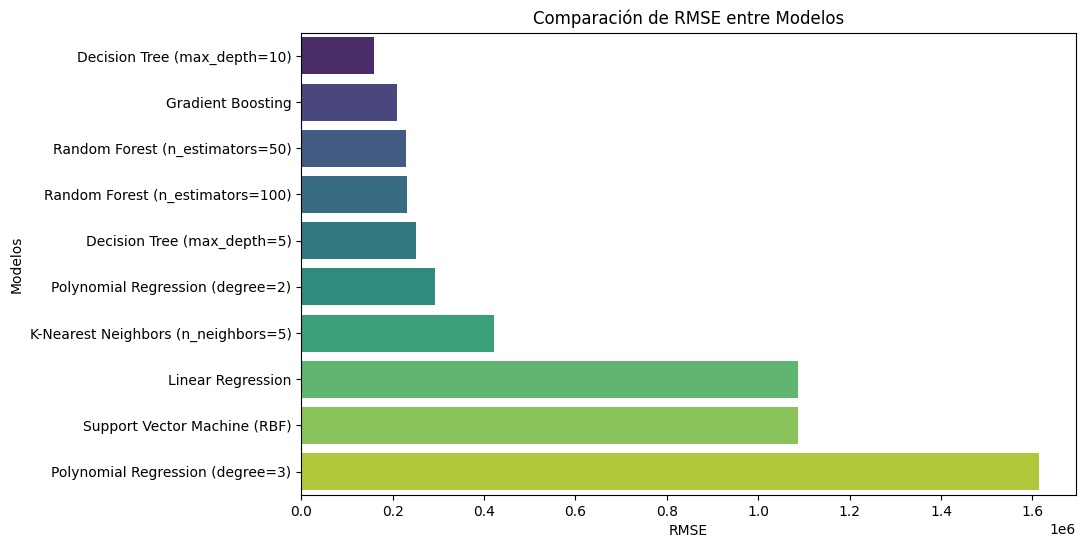


Mejor modelo: Decision Tree (max_depth=10)


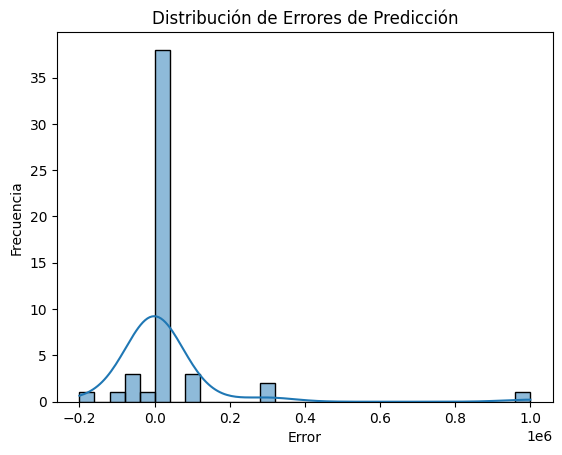

In [5]:
# ----------------------------------------------------------------------
# Evaluación del desempeño predictivo de los modelos
# ----------------------------------------------------------------------

# Diccionario para almacenar los resultados de RMSE
results = {}

# Evaluar cada modelo
for name, model in models.items():
    try:
        if "Polynomial" in name:
            # Extraer el grado del polinomio de la cadena de nombre del modelo usando expresión regular
            degree = int(re.search(r'\d+', name.split('=')[-1]).group())  # Extraer el número
            poly = PolynomialFeatures(degree=degree)
            X_train_poly = poly.fit_transform(X_train)
            X_test_poly = poly.transform(X_test)

            # Ajustar el modelo de regresión lineal con las características polinómicas
            linear_poly = LinearRegression()
            linear_poly.fit(X_train_poly, y_train)
            y_pred = linear_poly.predict(X_test_poly)
        else:
            # Para otros modelos
            if name in ["Support Vector Machine (RBF)", "K-Nearest Neighbors (n_neighbors=5)"]:
                # Usar datos escalados
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

        # Calcular RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        results[name] = rmse
    except Exception as e:
        print(f"Error con el modelo {name}: {e}")

# Mostrar resultados en formato tabular
results_df = pd.DataFrame(results.items(), columns=['Modelo', 'RMSE']).sort_values(by='RMSE')
print("\nResultados de RMSE para cada modelo:")
print(results_df)

# Visualización comparativa del RMSE
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df['RMSE'], y=results_df['Modelo'], palette="viridis")
plt.title('Comparación de RMSE entre Modelos')
plt.xlabel('RMSE')
plt.ylabel('Modelos')
plt.show()

# Mejor modelo y análisis de errores
best_model_name = results_df.iloc[0]['Modelo']
print(f"\nMejor modelo: {best_model_name}")

# Calcular errores de predicción
if "Polynomial" in best_model_name:
    degree = int(re.search(r'\d+', best_model_name.split('=')[-1]).group())
    poly = PolynomialFeatures(degree=degree)
    X_test_poly = poly.transform(X_test)
    errors = y_test - linear_poly.predict(X_test_poly)
else:
    if best_model_name in ["Support Vector Machine (RBF)", "K-Nearest Neighbors (n_neighbors=5)"]:
        errors = y_test - models[best_model_name].predict(X_test_scaled)
    else:
        errors = y_test - models[best_model_name].predict(X_test)

# Visualización de errores
sns.histplot(errors, kde=True, bins=30)
plt.title('Distribución de Errores de Predicción')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()

## 6. Validacion cruzada


Resultados de RMSE (K-Fold) para cada modelo:
                                     RMSE (K-Fold)  Desviación Estándar
Polynomial Regression (degree=2)      2.359410e+05         1.484690e+05
Decision Tree (max_depth=10)          4.566752e+05         3.118531e+05
Decision Tree (max_depth=5)           4.600074e+05         2.808712e+05
Gradient Boosting                     4.788510e+05         3.471843e+05
Random Forest (n_estimators=100)      4.845609e+05         3.778496e+05
Random Forest (n_estimators=50)       4.851659e+05         3.669196e+05
K-Nearest Neighbors (n_neighbors=5)   6.123542e+05         3.767110e+05
Support Vector Machine (RBF)          1.195757e+06         5.100669e+05
Polynomial Regression (degree=3)      4.261645e+06         3.689436e+06
Linear Regression                     1.788277e+07         1.227509e+07


<ipython-input-6-bd34d29b7652>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cv_results_df['RMSE (K-Fold)'], y=cv_results_df.index, palette="viridis")


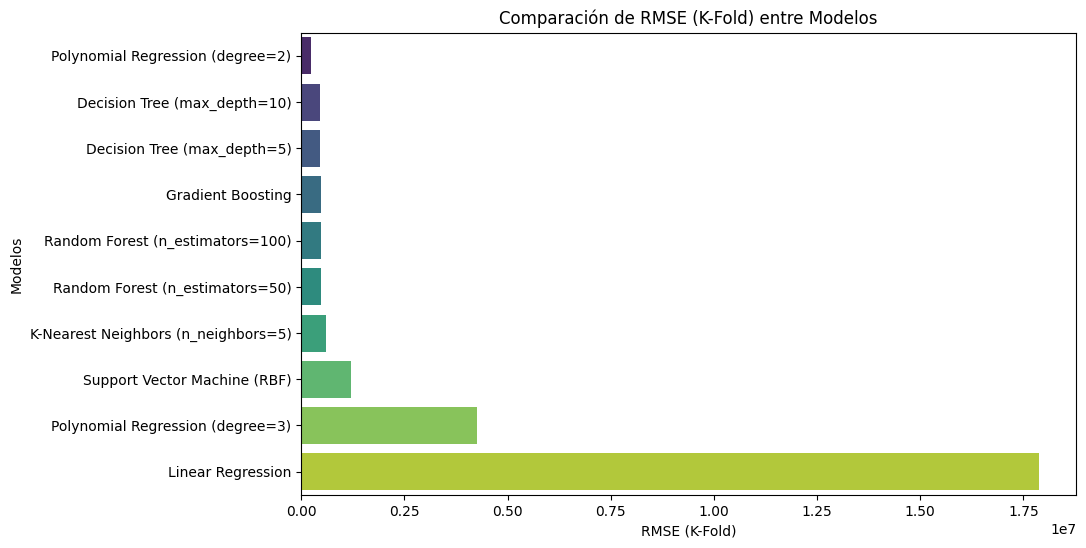


Mejor modelo basado en K-Fold: Polynomial Regression (degree=2)

Comparación RMSE (Conjunto de prueba vs. K-Fold):
Polynomial Regression (degree=2) - RMSE en conjunto de prueba: 292376.06
Polynomial Regression (degree=2) - RMSE en K-Fold: 235941.00


In [6]:
# ----------------------------------------------------------------------
# Validación Cruzada K-Fold
# ----------------------------------------------------------------------

# Número de pliegues
k_folds = 5

# Diccionario para almacenar los resultados de la validación cruzada
cv_results = {}

# Evaluar cada modelo usando validación cruzada K-Fold
for name, model in models.items():
    try:
        if "Polynomial" in name:
            # Extraer el grado del polinomio
            degree = int(re.search(r'\d+', name.split('=')[-1]).group())
            poly = PolynomialFeatures(degree=degree)
            X_poly = poly.fit_transform(X)  # Transformar todas las características de X

            # Validación cruzada con regresión lineal
            cv_scores = cross_val_score(LinearRegression(), X_poly, y, cv=k_folds, scoring='neg_mean_squared_error')
        else:
            # Escalar para modelos sensibles
            if name in ["Support Vector Machine (RBF)", "K-Nearest Neighbors (n_neighbors=5)"]:
                X_scaled = scaler.fit_transform(X)
                cv_scores = cross_val_score(model, X_scaled, y, cv=k_folds, scoring='neg_mean_squared_error')
            else:
                cv_scores = cross_val_score(model, X, y, cv=k_folds, scoring='neg_mean_squared_error')

        # Calcular RMSE promedio
        rmse_cv_mean = np.sqrt(-cv_scores.mean())
        rmse_cv_std = np.sqrt(-cv_scores).std()
        cv_results[name] = (rmse_cv_mean, rmse_cv_std)
    except Exception as e:
        print(f"Error con el modelo {name}: {e}")

# Resultados tabulares
cv_results_df = pd.DataFrame.from_dict(cv_results, orient='index', columns=['RMSE (K-Fold)', 'Desviación Estándar'])
cv_results_df = cv_results_df.sort_values(by='RMSE (K-Fold)')

print("\nResultados de RMSE (K-Fold) para cada modelo:")
print(cv_results_df)

# Visualización
plt.figure(figsize=(10, 6))
sns.barplot(x=cv_results_df['RMSE (K-Fold)'], y=cv_results_df.index, palette="viridis")
plt.title('Comparación de RMSE (K-Fold) entre Modelos')
plt.xlabel('RMSE (K-Fold)')
plt.ylabel('Modelos')
plt.show()

# Mejor modelo basado en K-Fold
best_model_name_cv = cv_results_df.index[0]
print(f"\nMejor modelo basado en K-Fold: {best_model_name_cv}")

# Comparación entre validación cruzada y conjunto de prueba
print("\nComparación RMSE (Conjunto de prueba vs. K-Fold):")
print(f"{best_model_name_cv} - RMSE en conjunto de prueba: {results[best_model_name_cv]:.2f}")
print(f"{best_model_name_cv} - RMSE en K-Fold: {cv_results_df.loc[best_model_name_cv, 'RMSE (K-Fold)']:.2f}")

In [ ]:
column_names = filtered_data.columns
print(column_names)

In [ ]:
#Armo los datos
data_subset = filtered_data[["hourly_wage", "maxEducLevel", "age"]]
nlsy_subset = data_subset.dropna()

In [ ]:
#Reviso la forma de los datos
np.isnan(nlsy_subset).sum()

In [ ]:
# Separo las variables
X = nlsy_subset[["maxEducLevel", "age"]]

y=nlsy_subset[["hourly_wage"]]

In [ ]:
# Defino el tamaño de entranamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        test_size=0.3,
                                        train_size=0.7,
                                        random_state = 123
                                    )

In [ ]:
#predeccion
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [ ]:
# Estimacion del primer modelo
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train[['maxEducLevel']])
model1 =  LinearRegression().fit(X_train_poly,y_train)
model1.coef_
#prediction en dato de prueba
X_test_poly = poly.fit_transform(X_test[['maxEducLevel']])
y_hat_model1 = model1.predict(X_test_poly)
# Calculate Mean Squared Error
mse1 = mean_squared_error(y_test, y_hat_model1)
print(f'Mean Squared Error: {mse1}')

In [ ]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train[['maxEducLevel',"sex"]])
model2 =  LinearRegression().fit(X_train_poly,y_train)
X_test_poly = poly.fit_transform(X_test[['maxEducLevel',"sex"]])
y_hat_model2 = model2.predict(X_test_poly)
mse2 = mean_squared_error(y_test, y_hat_model2)
print(f'Mean Squared Error: {mse2}')

In [ ]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train[['maxEducLevel',"sex","sex*Oficio"]])
model3 =  LinearRegression().fit(X_train_poly,y_train)
X_test_poly = poly.fit_transform(X_test[['maxEducLevel',"sex","sex*Oficio"]])
y_hat_model3 = model3.predict(X_test_poly)
mse3 = mean_squared_error(y_test, y_hat_model3)
print(f'Mean Squared Error: {mse3}')

In [ ]:
#P6426 es cuanto tiempo lleva en el puesto
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train[['maxEducLevel',"P6426"]])
model4 =  LinearRegression().fit(X_train_poly,y_train)
X_test_poly = poly.fit_transform(X_test[['maxEducLevel',"P6426"]])
y_hat_model4 = model4.predict(X_test_poly)
mse4 = mean_squared_error(y_test, y_hat_model4)
print(f'Mean Squared Error: {mse4}')

#P6870 cantidad de personas que tiene la empresa donde trabaja 
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train[['maxEducLevel',"P6426","P6870"]])
model4 =  LinearRegression().fit(X_train_poly,y_train)
X_test_poly = poly.fit_transform(X_test[['maxEducLevel',"P6426","P6870"]])
y_hat_model4 = model4.predict(X_test_poly)
mse4 = mean_squared_error(y_test, y_hat_model4)
print(f'Mean Squared Error: {mse4}')